# Plotting Glider DVL Data with Pandas and Seaborn

In [12]:
import pandas as pd
import seaborn as sns 
import numpy as np
import importlib
import sys
import os
import datetime
from matplotlib import pyplot as plt 

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)

## Load or Parse DVL data 

In [14]:
reload_modules()
glider   = "sentinel"
# glider   = "unit_770"
unit_name = {"sentinel" : "Unit 250",
             "unit_770" : "Unit 770" }
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)
# filename = "01820002.pd0" # example of prime data set to work with
# filename = "01740000.pd0" # example of file not parsing correctly
# filename = "sk261222.pd0" # example of another cool mission (less bottom track, long dive)

filename = "01820002.pd0"
ts = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename, save=False)

________________________________________
- Parsing New File ---------------------
    input file: /Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/sentinel/01820002.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
- Parsing Complete ---------------------
    # ensembles:   2410
    parsing time:  5.472378
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords


## Profile and Odometry Plots

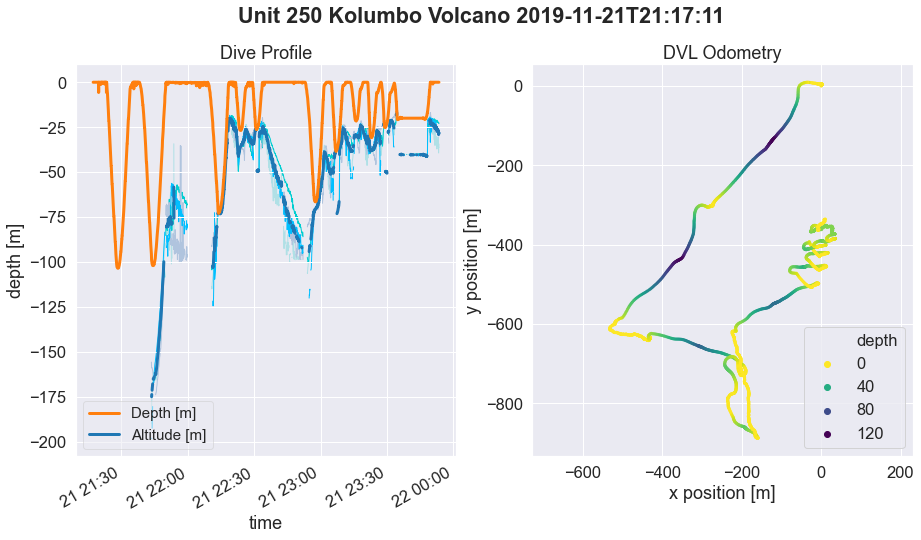

In [15]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1,2, figsize=(15,8))

########################################
# Plot Profile #########################
########################################
ts_sub = ts.df

# depth data
depth = -1 * ts_sub['depth']
line_plot = depth.plot(figsize=(15,8), linewidth=3, color='tab:orange', ax=ax[0])

# compute altitude estimate from the four vertical range estimates
# - does not account for pitch and roll of the vehicle 
h1 = ts_sub['btm_beam0_range']
h2 = ts_sub['btm_beam1_range']
h3 = ts_sub['btm_beam2_range']
h4 = ts_sub['btm_beam3_range']
altitude = depth - ((h1*h2)/(h1 + h2) + (h3*h4)/(h3 + h4))
altitude.plot(linewidth=3, color='tab:blue', zorder=1, ax=ax[0])

# bottom_track slant range data 
bt_ranges = ['btm_beam0_range','btm_beam1_range','btm_beam2_range','btm_beam3_range']
bt_colors = ['powderblue', 'darkturquoise', 'lightsteelblue', 'deepskyblue']
for i in range(len(bt_ranges)):
    bt_range  = depth - ts_sub[bt_ranges[i]]
    bt_range.plot(linewidth=1, color=bt_colors[i], zorder=0, ax=ax[0])
    
ax[0].set_ylabel('depth [m]')
ax[0].set_xlabel('time')
ax[0].set_title('Dive Profile')
ax[0].legend(['Depth [m]', 'Altitude [m]'], fontsize='small', loc='lower left', framealpha=0.5)



########################################
# Plot Odometry ########################
########################################
sns.scatterplot(
    x=ts.df.rel_pos_x,
    y=ts.df.rel_pos_y,
    palette='viridis_r',
    hue=ts.df.depth,
    linewidth=0,
    s=10,
    data=ts.df,
    ax=ax[1])
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.axis('equal')
plt.suptitle('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),), fontweight='bold')
plt.title('DVL Odometry')
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.legend(loc='lower right')
# plt.savefig('/Users/zduguid/Desktop/fig/%s/dive-profile-odometry/%s.jpg' % (glider, dt.isoformat()))

## Profile Plot

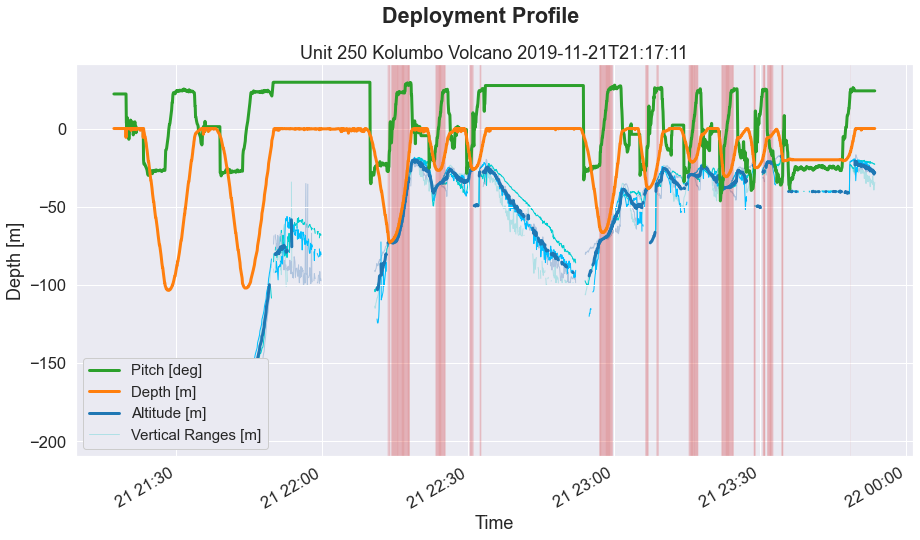

In [570]:
# sub-select time-window
# ts_sub = ts_csv['2019-11-21 22:00':]
ts_sub = ts.df
plot_pitch = True
plot_danger = True

# pitch data
sns.set(font_scale = 1.5)
pitch     = ts_sub['pitch']
if plot_pitch:
    line_plot = pitch.plot(figsize=(15,8), linewidth=3, color='tab:green')

# depth data
depth     = -1 * ts_sub['depth']
line_plot = depth.plot(figsize=(15,8), linewidth=3, color='tab:orange')

# compute altitude estimate from the four vertical range estimates
# - does not account for pitch and roll of the vehicle 
h1 = ts_sub['btm_beam0_range']
h2 = ts_sub['btm_beam1_range']
h3 = ts_sub['btm_beam2_range']
h4 = ts_sub['btm_beam3_range']
altitude = depth - ((h1*h2)/(h1 + h2) + (h3*h4)/(h3 + h4))
altitude.plot(linewidth=3, color='tab:blue', zorder=1)

# bottom_track slant range data 
bt_ranges = ['btm_beam0_range','btm_beam1_range','btm_beam2_range','btm_beam3_range']
bt_colors = ['powderblue', 'darkturquoise', 'lightsteelblue', 'deepskyblue']
for i in range(len(bt_ranges)):
    bt_range  = depth - ts_sub[bt_ranges[i]]
    bt_range.plot(linewidth=1, color=bt_colors[i], zorder=0)

# plot moments in time where the glider gets dangerously close to bottom 
window = 5    # window is used to estimate the time between measurements (not constant during deployment)
danger = 20   # threshold for what is considered dangerously close to the bottom
danger = ts_sub[(ts_sub.btm_beam0_range < danger) & 
                (ts_sub.btm_beam1_range < danger) & 
                (ts_sub.btm_beam2_range < danger) & 
                (ts_sub.btm_beam3_range < danger)]

if plot_danger:
    for time_stamp in danger.index:
        plt.axvspan(time_stamp, time_stamp + pd.Timedelta(seconds=window), color='tab:red', alpha=0.05)
        
# plotting labels 
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.legend(['Pitch [deg]', 'Depth [m]', 'Altitude [m]', 'Vertical Ranges [m]'], fontsize='small', loc='lower left',framealpha=1)
plt.suptitle('Deployment Profile', fontweight='bold')
plt.title('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),))
plt.ylabel('Depth [m]')
plt.xlabel('Time')
plt.savefig('/Users/zduguid/Desktop/fig/%s/dive-profile/%s.jpg' % (glider, dt.isoformat()))

## Odometry Plot

Text(0, 0.5, 'y position [m]')

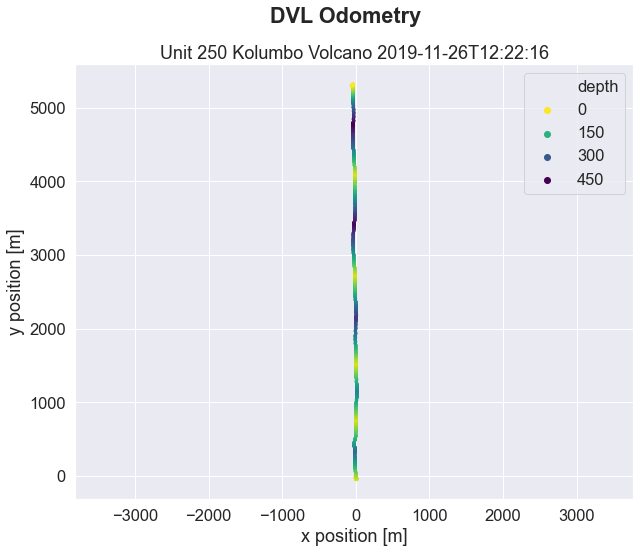

In [561]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(
    x=ts.df.rel_pos_x,
    y=ts.df.rel_pos_y,
    palette='viridis_r',
    hue=ts.df.depth,
    linewidth=0,
    s=10,
    data=ts.df)
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.axis('equal')
plt.suptitle('DVL Odometry', fontweight='bold')
plt.title('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),))
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
# plt.savefig('/Users/zduguid/Desktop/fig/%s/odometry/%s.jpg' % (glider, dt.isoformat()))


## Bottom Track Velocities

([<matplotlib.axis.YTick at 0x167e90450>,
 <a list of 13 Text major ticklabel objects>)

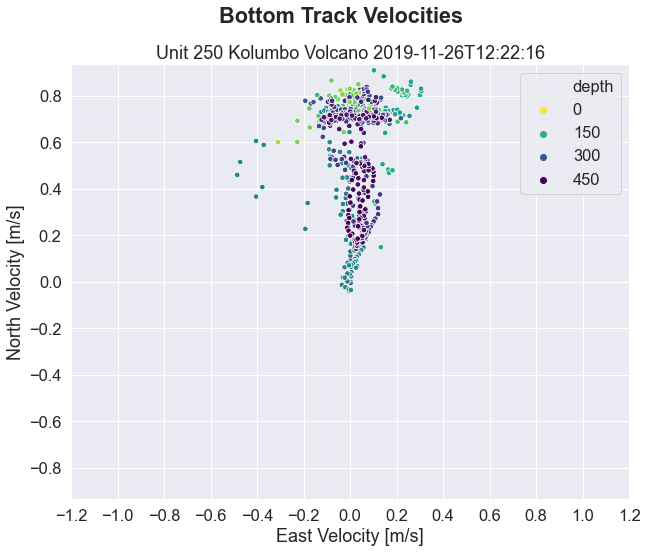

In [562]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=ts.df.abs_vel_btm_u,
                y=ts.df.abs_vel_btm_v,
                s=30,
                hue=ts.df.depth,
                palette='viridis_r',
                data=ts.df)
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.axis('equal')
plt.suptitle('Bottom Track Velocities', fontweight='bold')
plt.title('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),))
plt.xlabel('East Velocity [m/s]')
plt.ylabel('North Velocity [m/s]')
tick_spacing = np.arange(-1.2,1.4,0.2)
plt.xticks(tick_spacing)
plt.yticks(tick_spacing)
# plt.savefig('/Users/zduguid/Desktop/fig/%s/bottom-velocities/%s.jpg' % (glider, dt.isoformat()))

---

## Velocity Component Plot

Text(0, 0.5, 'Velocity [m/s]')

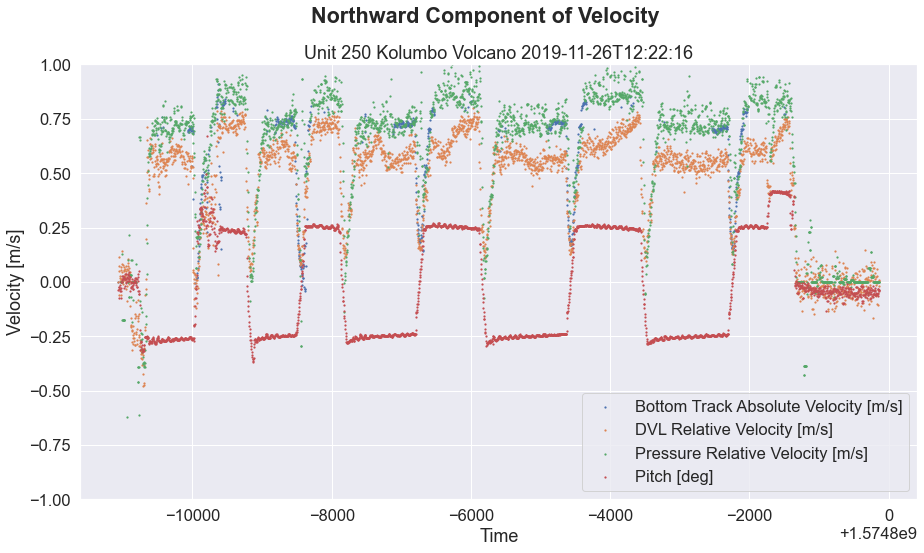

In [565]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# plot over ground velocity from bottom track
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.abs_vel_btm_v,
    data=ts.df,
    s=5,
    linewidth=0,
    label='Bottom Track Absolute Velocity [m/s]'
)

# plot relative velocity from DVL
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.rel_vel_dvl_v,
    data=ts.df,
    s=5,
    linewidth=0,
    label='DVL Relative Velocity [m/s]'
) 


# plot relative velocity from pressure
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.rel_vel_pressure_v.rolling(10).mean(),
    data=ts.df,
    s=5,
    linewidth=0,
    label='Pressure Relative Velocity [m/s]'
) 

# plot pitch to assess for any strong correlations 
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.pitch/100,
    data=ts.df,
    s=5,
    linewidth=0,
    label='Pitch [deg]'
)

ax.set(ylim=(-1, 1))
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.suptitle('Northward Component of Velocity', fontweight='bold')
plt.title('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),))
plt.xlabel('Time')
plt.ylabel('Velocity [m/s]')
# plt.savefig('/Users/zduguid/Documents/Arctic-NNA/software/dvl-nav/figs/debugging-odometry-3.png')
# np.max(ts.df.)

## Correlations Plot

Text(0.5, 1.0, 'DVL Feature Correlations Heatmap')

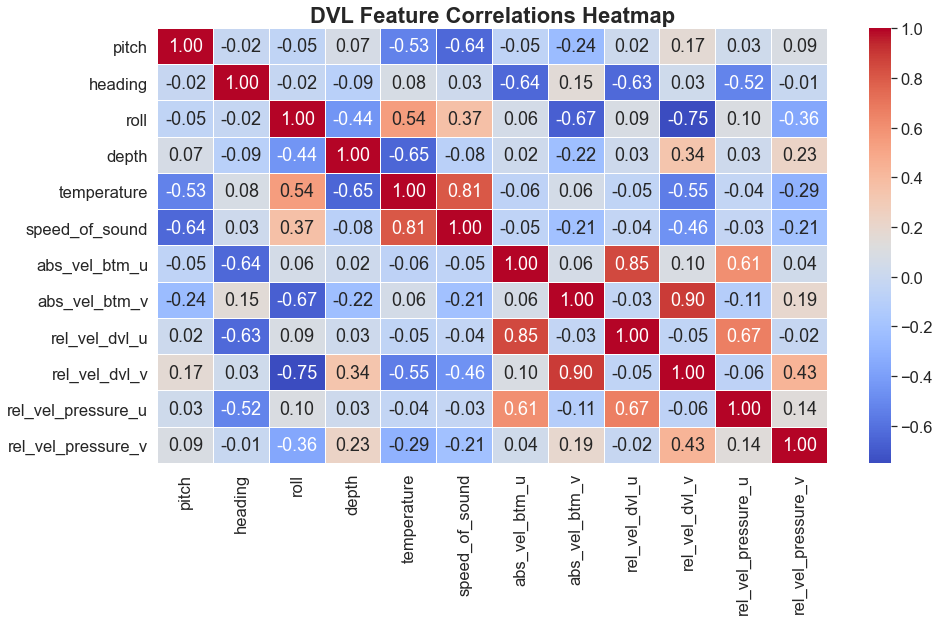

In [564]:
# down-select desired column headers for correlation data 
sub_cols = [
    'pitch', 
    'heading', 
    'roll', 
    'depth',
    'temperature',
    'speed_of_sound',
    'abs_vel_btm_u',
    'abs_vel_btm_v',
    'rel_vel_dvl_u',
    'rel_vel_dvl_v',
    'rel_vel_pressure_u',
    'rel_vel_pressure_v',
]

df = ts.df[sub_cols]

# compute correlations 
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

# plot heatmap given the correlations 
fig, (ax) = plt.subplots(1, 1, figsize=(15,8))
hm = sns.heatmap(corr, 
                 ax=ax,
#                  mask=mask,
                 cmap="coolwarm",
                 #square=True,
                 annot=True, 
                 fmt='.2f', 
                 #annot_kws={"size": 14},
                 linewidths=.05)

# fig.subplots_adjust(top=0.93)
ax.set_title('DVL Feature Correlations Heatmap', fontsize=22, fontweight='bold')
# plt.savefig('/Users/zduguid/Documents/Arctic-NNA/software/dvl-nav/figs/05-08-debugging-odometry/correlations-3-pressure-fixed.png')

## Absolute vs. Relative Velocities

Text(0, 0.5, 'Vertical Velocity [m/s]')

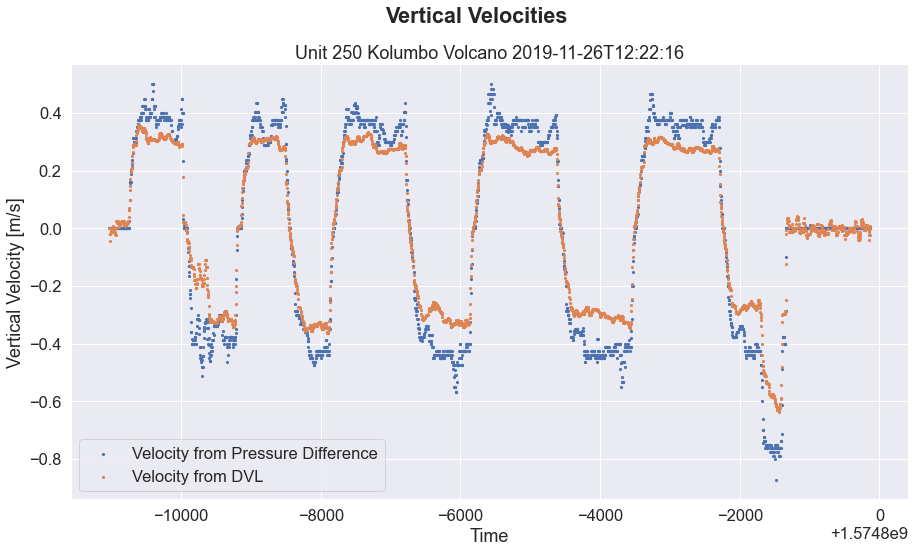

In [566]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# plot relative velocity from DVL
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.abs_vel_w.rolling(10).median(),
    data=ts.df,
    s=10,
    linewidth=0,
    label='Velocity from Pressure Difference'
) 

# plot relative velocity from DVL
sns.scatterplot(
    x=ts.df.time,
    y=ts.df.vel_bin0_beam2.rolling(10).median(),
    data=ts.df,
    s=10,
    linewidth=0,
    label='Velocity from DVL'
) 

dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.suptitle('Vertical Velocities', fontweight='bold')
plt.title('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),))
plt.xlabel('Time')
plt.ylabel('Vertical Velocity [m/s]')
# plt.savefig('/Users/zduguid/Documents/Arctic-NNA/software/dvl-nav/figs/05-08-debugging-odometry/vertical-velocities-rolling-median.png')

## Vertical Velocity Plot

In [567]:
# sub-select time-window
ts_sub=  ts_csv['2019-11-21 22:00':]
pitch =  ts_sub['pitch']
depth = -ts_sub['depth_of_transducer']

# plot depth data
sns.set(font_scale = 1.5)
depth_plot = depth.plot(figsize=(15,8), linewidth=3, color='tab:orange')

# create twin plot and plot beam data 
speed_plot = depth_plot.twinx()
beam3_roll = beam3.rolling(10).mean()
beam3.plot(figsize=(15,8),      linewidth=3, alpha=0.5,  color='tab:purple')
beam3_roll.plot(figsize=(15,8), linewidth=3, style='--', color='tab:purple')

# plotting labels 
depth_plot.legend(['Depth [m]'],            fontsize='medium', loc='lower left',  framealpha=1)
speed_plot.legend(['Vertical Speed [m/s]'], fontsize='medium', loc='lower right', framealpha=1)
plt.title('Sentinel Deployment in Kolumbo Greece, 21 Nov 2019', fontsize=30)
depth_plot.set_ylabel('[m]')
speed_plot.set_ylabel('[m/s]')

# set axis and legend information
depth_plot.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))
speed_plot.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))
depth_plot.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.0f'))
speed_plot.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
depth_plot.tick_params(axis='both', which='both', length=0)
speed_plot.tick_params(axis='both', which='both', length=0)

# saving the plot
plt.show()
fig = depth_plot.get_figure()
# fig.savefig("figs/bottom_track6")

NameError: name 'ts_csv' is not defined